In [2]:
!pip install -q pmdarima holidays catboost optuna

     |████████████████████████████████| 1.8 MB 40.0 MB/s 
     |████████████████████████████████| 76.6 MB 1.3 MB/s 
     |████████████████████████████████| 348 kB 70.2 MB/s 
     |████████████████████████████████| 9.9 MB 19.0 MB/s 
     |████████████████████████████████| 209 kB 73.1 MB/s 
     |████████████████████████████████| 81 kB 10.4 MB/s 
     |████████████████████████████████| 78 kB 7.9 MB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
     |████████████████████████████████| 112 kB 73.5 MB/s 
     |████████████████████████████████| 147 kB 69.0 MB/s 


In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import gc
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
from statsmodels.api import tsa
import pmdarima
import holidays
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import optuna

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# read data
train = pd.read_csv('/content/drive/MyDrive/train_data.csv')
valid = pd.read_csv('/content/drive/MyDrive/valid.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')

train.head()

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...
4,1565568000,30.309158,59.932612,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...


In [6]:
valid.rename(columns={'hour':'timestamp'}, inplace=True)
valid.head()

,timestamp,lat,lon,point,sum,error
0,1582448400,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402
1,1582225200,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291
2,1581260400,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735
3,1581958800,59.935988,30.324878,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735
4,1582779600,59.933737,30.306912,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.554735


In [7]:
test.rename(columns={'hour': 'timestamp'}, inplace=True)
test.head()

,timestamp,lat,lon,point,sum,error
0,1582711200,59.934863,30.331616,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,7,0.370265
1,1581937200,59.940488,30.329370,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,6,0.754735
2,1581523200,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,5,3.754735
3,1581512400,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,16,4.088069
4,1581771600,59.939363,30.315895,0101000020E61000006141807FDE503E40A554BF083DF8...,10,2.088069


In [8]:
len(valid), len(test)

(709, 700)

In [9]:
train['timestamp'].nunique(), train['point'].nunique()

(9504, 7041)

In [10]:
toptail_coord = np.array([sorted(train['lon'].unique())[:25], 
                          sorted(train['lat'].unique())[:25],
                          sorted(train['lon'].unique())[-25:],
                          sorted(train['lat'].unique())[-25:]]).T
pd.DataFrame(toptail_coord, columns=['Head Lon', 'Head Lat', 'Tail Lon', 'Tail Lat'])

,Head Lon,Head Lat,Tail Lon,Tail Lat
0,-48.410211,-1.390007,30.542720,60.025871
1,0.000000,0.000000,30.547211,60.026993
2,18.846655,35.032142,30.549457,60.028115
3,20.486080,41.303760,30.551703,60.029237
4,23.690820,42.289870,30.553949,60.030359
5,24.000739,42.996900,30.556194,60.031480
6,29.406351,43.689392,30.558440,60.032602
7,30.089070,52.116679,30.560686,60.033724
8,30.091316,54.715007,30.562932,60.034846
9,30.093562,54.774637,30.565178,60.035967


In [11]:
le = LabelEncoder()
le.fit(train['point'])

LabelEncoder()

In [12]:
# remove outlier data based on lat lon (meaning the data isn't from spb area)
# SPB Longitude: 30.308611
# SPB Latitude: 59.937500
# Longitude Range: 29.406351 - 32.047398
# Latitude Range: 59.656930 - 60.374090

lon_min, lon_max = 29.406351, 32.047398
lat_min, lat_max = 59.656930, 60.374090

train_old_size = len(train)
valid_old_size = len(valid)
print(f'Original train size: {train_old_size}.')
print(f'Original valid size: {valid_old_size}.')
train = train[(train['lon'] >= lon_min) &\
                         (train['lon'] <= lon_max) &\
                         (train['lat'] >= lat_min) &\
                         (train['lat'] <= lat_max)]

# valid = valid[(valid['lon'] >= lon_min) &\
#                          (valid['lon'] <= lon_max) &\
#                          (valid['lat'] >= lat_min) &\
#                          (valid['lat'] <= lat_max)]

print(f'Without outlier train size: {len(train)}.')
# print(f'Without outlier valid size: {len(valid)}.')
print(f'{train_old_size - len(train)} outliers train data dropped.')
# print(f'{valid_old_size - len(valid)} outliers valid data dropped.')

Original train size: 8526526.
Original valid size: 709.
Without outlier train size: 8450458.
76068 outliers train data dropped.


In [13]:
# check filtered lat lon
fig = px.scatter_mapbox(train.drop_duplicates('point'), 
                        lat='lat', 
                        lon='lon',
                        zoom=9,
                        size='likescount',
                        height=500,
                        width=1000)
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={'r':0, 't':0, 'l':0, 'b':0})
fig.show()

In [14]:
# sort data by timestamp
train = train.sort_values(by=['timestamp'])
display(train.head())

print(f'Oldest post: {datetime.fromtimestamp(train.iloc[0,0])}')
print(f'Latest post: {datetime.fromtimestamp(train.iloc[-1,0])}')

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point
5218705,1546300800,30.286700,59.986577,49,0,0,0,0,0,0,0,0101000020E6100000B1558A2865493E4021743A2748FE...
5218597,1546300800,30.351828,59.931487,22,0,23,1,0,1,0,2,0101000020E610000050EDAE60115A3E40CAE971F73AF7...
5218718,1546300800,30.291191,59.937113,25,0,0,0,0,0,0,0,0101000020E61000002D2BB0848B4A3E400C288C4EF3F7...
5218717,1546300800,30.372040,59.953984,138,2,232,4,13,1,0,2,0101000020E6100000062E59FF3D5F3E408F05D6231CFA...
5218716,1546300800,30.313649,59.939363,209,0,80,4,3,0,0,4,0101000020E6100000A4566D514B503E40A554BF083DF8...


Oldest post: 2019-01-01 00:00:00
Latest post: 2020-01-31 23:00:00


In [15]:
# analyze timestamp
unique_time = train.timestamp.unique()
print(f'There are {len(unique_time)} timestamps in train dataset.')
for ut in unique_time[:5]:
    print(f'Time: {datetime.fromtimestamp(ut)}')
print()
for ut in unique_time[-5:]:
    print(f'Time: {datetime.fromtimestamp(ut)}')

There are 9504 timestamps in train dataset.
Time: 2019-01-01 00:00:00
Time: 2019-01-01 01:00:00
Time: 2019-01-01 02:00:00
Time: 2019-01-01 03:00:00
Time: 2019-01-01 04:00:00

Time: 2020-01-31 19:00:00
Time: 2020-01-31 20:00:00
Time: 2020-01-31 21:00:00
Time: 2020-01-31 22:00:00
Time: 2020-01-31 23:00:00


In [16]:
# timestamp represent hourly data
# and the whole data represent 13 months publications (01 January 2019 - 31 January 2020)
# so the total timestamp should be 24 * 365 + 24 * 31
full_timestamp = 24 * 365 + 24 * 31
full_timestamp

9504

In [17]:
# group data and count publications based on time (hour) and point (coordinate)
train['sum'] = 1
train_grouped = train.groupby(['timestamp', 'point'], as_index=False).size()\
                    .sort_values('timestamp', ascending=True)\
                    .rename(columns={'size': 'sum'})
train_grouped.head()

,timestamp,point,sum
0,1546300800,0101000020E610000002BF48199F3F3E4010C569574E02...,1
152,1546300800,0101000020E61000009E01B90998523E40E4A1F770CEF7...,1
153,1546300800,0101000020E61000009EE75C6BAC303E401DAC68F66CFE...,1
154,1546300800,0101000020E6100000A4566D514B503E4006FC5DE561F8...,7
155,1546300800,0101000020E6100000A4566D514B503E406DAFAAC186F8...,1


In [18]:
train_grouped.timestamp.nunique()

9504

In [19]:
train_grouped.sort_values('sum', ascending=False).head()

,timestamp,point,sum
2887357,1573920000,0101000020E610000050D352C225383E4030E11C588EFC...,600
2599983,1571504400,0101000020E610000050D352C225383E4030E11C588EFC...,443
2887967,1573923600,0101000020E610000050D352C225383E4030E11C588EFC...,442
2526936,1570903200,0101000020E610000050D352C225383E4030E11C588EFC...,428
1669633,1563742800,0101000020E6100000597DBB518C333E400262E887FEFD...,426


In [20]:
# encode point column
points = list(set(list(train_grouped['point'].unique()) + list(valid['point'].unique())))
points = {k: v for v, k in enumerate(points)}

In [21]:
# feature engineering
ru_holidays = holidays.Russia(years=[2019, 2020])

def is_holiday(date):
    weekday = date.weekday()
    if date in ru_holidays or weekday == 5 or weekday == 6:
        return 1
    else:
        return 0

# time features
train_grouped['date'] = train_grouped['timestamp'].map(lambda x: datetime.fromtimestamp(x).date())
train_grouped['year'] = train_grouped['timestamp'].map(lambda x: datetime.fromtimestamp(x).year)
train_grouped['month'] = train_grouped['timestamp'].map(lambda x: datetime.fromtimestamp(x).month)
train_grouped['day'] = train_grouped['timestamp'].map(lambda x: datetime.fromtimestamp(x).day)
train_grouped['weekday'] = train_grouped['timestamp'].map(lambda x: datetime.fromtimestamp(x).weekday())
train_grouped['hour'] = train_grouped['timestamp'].map(lambda x: datetime.fromtimestamp(x).hour)
train_grouped['is_weekend'] = train_grouped['weekday'].map(lambda x: 1 if x > 4 and x < 7 else 0)
train_grouped['is_holiday'] = train_grouped['date'].map(is_holiday)
# encode location
train_grouped['point_new'] = train_grouped['point'].map(lambda x: points[x])

train_grouped.head()

,timestamp,point,sum,date,year,month,day,weekday,hour,is_weekend,is_holiday,point_new
0,1546300800,0101000020E610000002BF48199F3F3E4010C569574E02...,1,2019-01-01,2019,1,1,1,0,0,1,4043
152,1546300800,0101000020E61000009E01B90998523E40E4A1F770CEF7...,1,2019-01-01,2019,1,1,1,0,0,1,2630
153,1546300800,0101000020E61000009EE75C6BAC303E401DAC68F66CFE...,1,2019-01-01,2019,1,1,1,0,0,1,4750
154,1546300800,0101000020E6100000A4566D514B503E4006FC5DE561F8...,7,2019-01-01,2019,1,1,1,0,0,1,119
155,1546300800,0101000020E6100000A4566D514B503E406DAFAAC186F8...,1,2019-01-01,2019,1,1,1,0,0,1,5487


In [22]:
# valid feature engineering
valid['date'] = valid['timestamp'].map(lambda x: datetime.fromtimestamp(x).date())
valid['year'] = valid['timestamp'].map(lambda x: datetime.fromtimestamp(x).year)
valid['month'] = valid['timestamp'].map(lambda x: datetime.fromtimestamp(x).month)
valid['day'] = valid['timestamp'].map(lambda x: datetime.fromtimestamp(x).day)
valid['weekday'] = valid['timestamp'].map(lambda x: datetime.fromtimestamp(x).weekday())
valid['hour'] = valid['timestamp'].map(lambda x: datetime.fromtimestamp(x).hour)
valid['is_weekend'] = valid['weekday'].map(lambda x: 1 if x > 4 and x < 7 else 0)
valid['is_holiday'] = valid['date'].map(is_holiday)
# encode location
valid['point_new'] = valid['point'].map(lambda x: points[x])

valid.sort_values('timestamp', inplace=True)
valid.head()

,timestamp,lat,lon,point,sum,error,date,year,month,day,weekday,hour,is_weekend,is_holiday,point_new
595,1580547600,59.932612,30.250767,0101000020E6100000C1A95B4732403E40494A4ED65FF7...,12,1.759517,2020-02-01,2020,2,1,5,9,1,1,6944
594,1580551200,60.034846,30.419201,0101000020E6100000B16FE6C6506B3E40504B47D37504...,6,1.754735,2020-02-01,2020,2,1,5,10,1,1,4028
145,1580551200,59.931487,30.360811,0101000020E61000004D98FA185E5C3E40CAE971F73AF7...,6,0.045265,2020-02-01,2020,2,1,5,10,1,1,1762
376,1580551200,59.893208,30.515770,0101000020E6100000C2DD138409843E4009249E9F54F2...,11,2.421402,2020-02-01,2020,2,1,5,10,1,1,579
551,1580554800,59.929237,30.288946,0101000020E61000006E409D56F8493E400A41C338F1F6...,25,0.192672,2020-02-01,2020,2,1,5,11,1,1,5947


In [23]:
# prepare train test data
X_train = train_grouped.drop(['timestamp', 'point', 'date', 'sum'], axis=1)
y_train = train_grouped['sum']

X_valid = valid.drop(['timestamp', 'point', 'date', 'lat', 'lon', 'sum', 'error'], axis=1)
y_valid = valid['sum'].to_numpy()

In [24]:
# eval
def metrics(prediction, ground_truth):
    return np.mean(np.abs(prediction - ground_truth) / prediction)

In [25]:
catboost = CatBoostRegressor(verbose=False, random_state=42, task_type='GPU', depth=3)
catboost.fit(X_train, y_train)

In [26]:
cat_pred = catboost.predict(X_valid)
metrics(cat_pred, y_valid)

1.8390921387632153

In [27]:
catboost.get_params()

{'depth': 3,
 'loss_function': 'RMSE',
 'verbose': False,
 'task_type': 'GPU',
 'random_state': 42}

In [28]:
xgboost = XGBRegressor(random_state=42, tree_method='gpu_hist', subsample=0.75, n_estimators=1000)
xgboost.fit(X_train, y_train)

[18:43:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000, random_state=42, subsample=0.75,
             tree_method='gpu_hist')

In [29]:
xgb_pred = xgboost.predict(X_valid)
metrics(xgb_pred, y_valid)

1.5215651719710797

In [30]:
xgboost.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 1000,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.75,
 'verbosity': 1,
 'tree_method': 'gpu_hist'}

In [31]:
results = pd.DataFrame(np.array([y_valid, xgb_pred, cat_pred, valid['error']]).T, columns=['ground_truth', 'xgb', 'catboost', 'base_error'])

In [32]:
# np.mean(np.abs(prediction - ground_truth) / prediction)
results['xgb_error'] = np.abs(results['xgb'] - results['ground_truth']) / results['xgb']
results['cat_error'] = np.abs(results['catboost'] - results['ground_truth']) / results['catboost']
results.head()

,ground_truth,xgb,catboost,base_error,xgb_error,cat_error
0,12.0,5.992098,5.011291,1.759517,1.002637,1.394593
1,6.0,2.192162,2.279675,1.754735,1.737024,1.631954
2,6.0,3.737850,3.095958,0.045265,0.605201,0.938011
3,11.0,3.664376,3.081694,2.421402,2.001875,2.569465
4,25.0,11.385680,7.537825,0.192672,1.195741,2.316607


In [33]:
# test feature engineering
test['date'] = test['timestamp'].map(lambda x: datetime.fromtimestamp(x).date())
test['year'] = test['timestamp'].map(lambda x: datetime.fromtimestamp(x).year)
test['month'] = test['timestamp'].map(lambda x: datetime.fromtimestamp(x).month)
test['day'] = test['timestamp'].map(lambda x: datetime.fromtimestamp(x).day)
test['weekday'] = test['timestamp'].map(lambda x: datetime.fromtimestamp(x).weekday())
test['hour'] = test['timestamp'].map(lambda x: datetime.fromtimestamp(x).hour)
test['is_weekend'] = test['weekday'].map(lambda x: 1 if x > 4 and x < 7 else 0)
test['is_holiday'] = test['date'].map(is_holiday)
# encode location
test['point_new'] = test['point'].map(lambda x: points[x])

test.sort_values('timestamp', inplace=True)
test.head()

,timestamp,lat,lon,point,sum,error,date,year,month,day,weekday,hour,is_weekend,is_holiday,point_new
417,1580536800,59.931487,30.354073,0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...,7,1.088069,2020-02-01,2020,2,1,5,6,1,1,1521
641,1580536800,59.893208,30.515770,0101000020E6100000C2DD138409843E4009249E9F54F2...,8,2.754735,2020-02-01,2020,2,1,5,6,1,1,579
171,1580544000,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,13,0.379735,2020-02-01,2020,2,1,5,8,1,1,5197
167,1580551200,59.982083,30.199114,0101000020E61000009A92A823F9323E40DDC94EE7B4FD...,6,0.254735,2020-02-01,2020,2,1,5,10,1,1,6723
64,1580551200,60.039332,30.322632,0101000020E61000009E01B90998523E40888919D70805...,7,5.754735,2020-02-01,2020,2,1,5,10,1,1,5100


In [34]:
X_test = test.drop(['timestamp', 'point', 'date', 'lat', 'lon', 'sum', 'error'], axis=1)
y_test = test['sum'].to_numpy()

In [35]:
cat_pred_test = catboost.predict(X_test)
metrics(cat_pred_test, y_test)

1.8638957504574085

In [36]:
cat_pred_df = pd.DataFrame(cat_pred_test, columns=['sum_pred'])
cat_pred_df['date'] = test.date
cat_pred_df['lat'] = test.lat
cat_pred_df['lon'] = test.lon
cat_pred_df['timestamp'] = test.timestamp
cat_pred_df['point_new'] = test.point_new
cat_pred_df.head()

,sum_pred,date,lat,lon,timestamp,point_new
0,2.033512,2020-02-26,59.934863,30.331616,1582711200,4317
1,2.598671,2020-02-17,59.940488,30.329370,1581937200,5153
2,3.764475,2020-02-12,59.905597,30.297929,1581523200,823
3,7.133462,2020-02-12,59.921359,30.356319,1581512400,5197
4,2.764488,2020-02-15,59.939363,30.315895,1581771600,1116


In [37]:
# check filtered lat lon
fig = px.scatter_mapbox(cat_pred_df, 
                        lat='lat', 
                        lon='lon',
                        zoom=9,
                        size='sum_pred',
                        height=500,
                        width=1000)
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={'r':0, 't':0, 'l':0, 'b':0})
fig.show()

In [38]:
xgb_pred_test = xgboost.predict(X_test)
metrics(xgb_pred_test, y_test)

1.4005341699809346

In [39]:
xgb_pred_df = pd.DataFrame(xgb_pred_test, columns=['sum_pred'])
xgb_pred_df['date'] = test.date
xgb_pred_df['lat'] = test.lat
xgb_pred_df['lon'] = test.lon
xgb_pred_df['timestamp'] = test.timestamp
xgb_pred_df['point_new'] = test.point_new
xgb_pred_df.head()

,sum_pred,date,lat,lon,timestamp,point_new
0,11.046863,2020-02-26,59.934863,30.331616,1582711200,4317
1,3.051846,2020-02-17,59.940488,30.329370,1581937200,5153
2,4.608908,2020-02-12,59.905597,30.297929,1581523200,823
3,9.367582,2020-02-12,59.921359,30.356319,1581512400,5197
4,3.559579,2020-02-15,59.939363,30.315895,1581771600,1116


In [40]:
# check filtered lat lon
fig = px.scatter_mapbox(xgb_pred_df, 
                        lat='lat', 
                        lon='lon',
                        zoom=9,
                        size='sum_pred',
                        height=500,
                        width=1000)
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={'r':0, 't':0, 'l':0, 'b':0})
fig.show()

In [151]:
test_group = test.groupby(['point_new', 'date'], as_index=False)['sum'].sum()
# find the popular and unpopular points
test_group_pop = test_group.groupby(['point_new'])['sum'].sum()
print(test_group_pop[test_group_pop == test_group_pop.max()].head())
print(test_group_pop[(test_group_pop >= test_group_pop.min()) & (test_group_pop <= 50)].sort_values(ascending=False).head())

point_new
1521    308
Name: sum, dtype: int64
point_new
5100    48
5941    48
3012    45
1759    44
2228    43
Name: sum, dtype: int64


In [152]:
test_1521 = test_group[test_group.point_new == 1521]
test_5100 = test_group[test_group.point_new == 5100]

In [153]:
xgb_pred_group = xgb_pred_df.groupby(['point_new', 'date'], as_index=False)['sum_pred'].sum()
xgb_pred_1521 = xgb_pred_group[xgb_pred_group.point_new == 1521]
xgb_pred_5100 = xgb_pred_group[xgb_pred_group.point_new == 5100]

In [154]:
xgb_pred_5100.head()

,point_new,date,sum_pred
369,5100,2020-02-01,3.433701
370,5100,2020-02-08,18.551693
371,5100,2020-02-09,2.358006
372,5100,2020-02-11,7.832216
373,5100,2020-02-24,11.629211


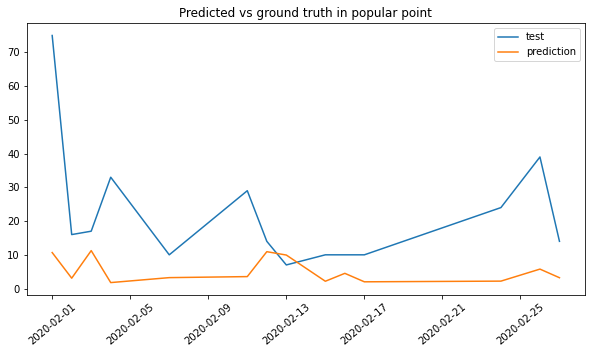

In [155]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(test_1521['date'], test_1521['sum'], label='test')
ax.plot(xgb_pred_1521['date'], xgb_pred_1521['sum_pred'], label='prediction')
ax.legend()
plt.title('Predicted vs ground truth in popular point')
plt.xticks(rotation=40)
plt.show()

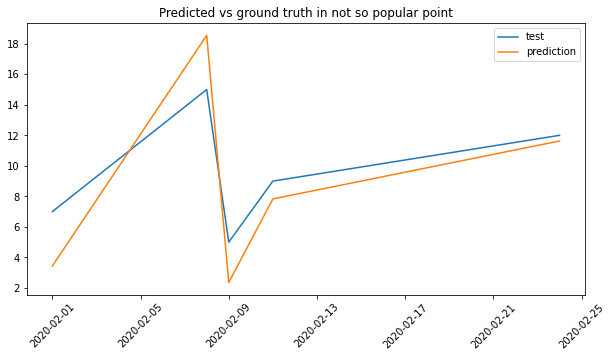

In [157]:
plt.figure(figsize=(10, 5))
plt.plot(test_5100['date'], test_5100['sum'], label='test')
plt.plot(xgb_pred_5100['date'], xgb_pred_5100['sum_pred'], label='prediction')
plt.legend()
plt.title('Predicted vs ground truth in not so popular point')
plt.xticks(rotation=45)
plt.show()

### Data Analysis

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import gc
from tqdm import tqdm
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML for Industrial Data/First Task/train_data.csv')
valid = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML for Industrial Data/First Task/valid.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML for Industrial Data/First Task/test.csv')

In [ ]:
import holidays
ru_holidays = holidays.Russia(years=[2019, 2020])
def is_holiday(date):
    weekday = date.weekday()
    if date in ru_holidays or weekday == 5 or weekday == 6:
        return 1
    else:
        return 0

In [ ]:
train['is_holiday'] = train['date'].map(is_holiday)
train['date'] = train['timestamp'].map(lambda x: datetime.fromtimestamp(x).date())
train['year'] = train['timestamp'].map(lambda x: datetime.fromtimestamp(x).year)
train['month'] = train['timestamp'].map(lambda x: datetime.fromtimestamp(x).month)
train['day'] = train['timestamp'].map(lambda x: datetime.fromtimestamp(x).day)
train['weekday'] = train['timestamp'].map(lambda x: datetime.fromtimestamp(x).weekday())
train['hour'] = train['timestamp'].map(lambda x: datetime.fromtimestamp(x).hour)
train['is_weekend'] = train['weekday'].map(lambda x: 1 if x > 4 and x < 7 else 0)

#### Peak hour?

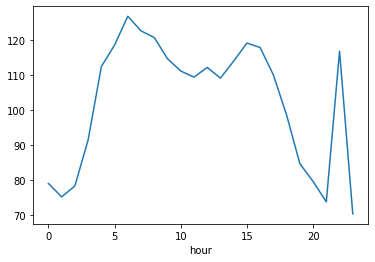

In [ ]:
train.groupby('hour')['likescount'].mean().plot()

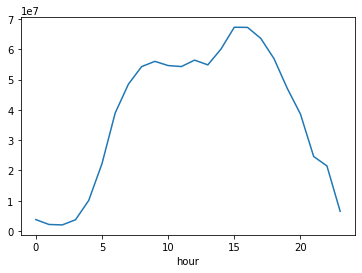

In [ ]:
train.groupby('hour')['likescount'].sum().plot()

Considering the amount of likes given in each hour, according to this dataset it seems that the afternoon ( 14-17) is the best time to post and reach more people

#### Days vs likes_count

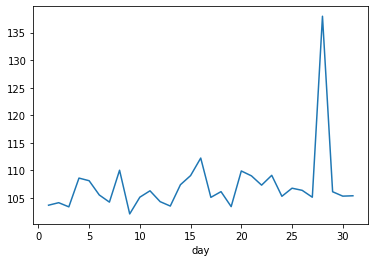

In [ ]:
train.groupby('day')['likescount'].mean().plot()

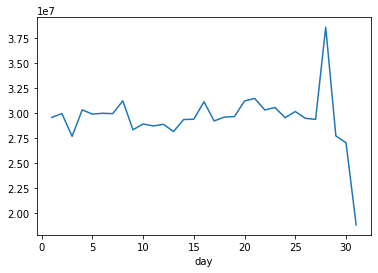

In [ ]:
train.groupby('day')['likescount'].sum().plot()

The end of the month has more likes_count, it could be because we have The Christmas and the end of the year holidays so the mean and sum of the likes_count over the whole months is baised according to that

#### Month vs likes_count?

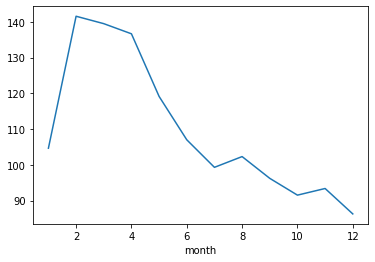

In [ ]:
train.groupby('month')['likescount'].mean().plot()

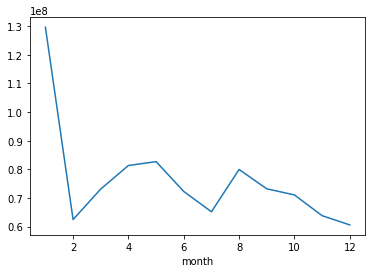

In [ ]:
train.groupby('month')['likescount'].sum().plot()

The first month has the most likes_count, the begining of the new year and the new year break could be the reason.

Do holidays effect how people engage in social media ?

In [ ]:
holiday_effect = train.groupby('is_holiday')['likescount'].sum()
holiday_effect

is_holiday
0    615908314
1    299234411
Name: likescount, dtype: int64

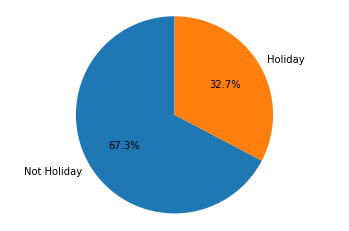

In [ ]:
import matplotlib.pyplot as plt

labels = 'Not Holiday', 'Holiday'
sizes = holiday_effect.values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

It seems that ~33% of the likes were on holidays and it can be considered a big precentages relatively comparing the count of ordinary and holiday days

In [ ]:
holiday_effect_mean = train.groupby('is_holiday')['likescount'].mean()
holiday_effect_mean

is_holiday
0    112.546636
1     97.979411
Name: likescount, dtype: float64

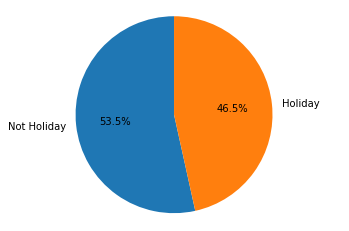

In [ ]:
labels = 'Not Holiday', 'Holiday'
sizes = holiday_effect_mean.values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Do weekends effect how people engage in social media ?

In [ ]:
weekend_effect = train.groupby('is_weekend')['likescount'].sum()
weekend_effect

is_weekend
0    656137618
1    259005107
Name: likescount, dtype: int64

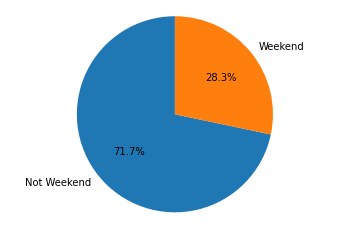

In [ ]:
labels = 'Not Weekend', 'Weekend'
sizes = weekend_effect.values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
weekend_effect_mean = train.groupby('is_weekend')['likescount'].mean()
weekend_effect_mean

is_weekend
0    111.374959
1     98.283826
Name: likescount, dtype: float64

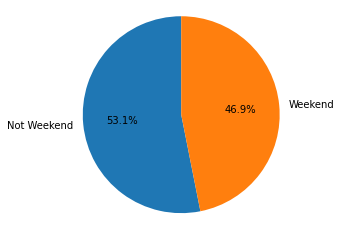

In [ ]:
labels = 'Not Weekend', 'Weekend'
sizes = weekend_effect_mean.values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()